In [ ]:
%pip install langchain-community chromadb sentence-transformers faiss-cpu requests pillow python-multipart opencv-python

In [22]:
import json
import requests
import base64
import os
from typing import List, Dict, Any
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from PIL import Image, ImageDraw, ImageFont
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [23]:
# Set up image directory - use your actual resume images here
IMAGE_DIR = "/Users/siddharthshailendra/Resume_Shortlister_using_llm_basic/resume_images"
os.makedirs(IMAGE_DIR, exist_ok=True)

In [24]:
# Multimodal LLM class that can handle both text and images
class MultimodalOllama:
    def __init__(self, model_name="llava:latest"):
        self.model_name = model_name
        self.base_url = "http://localhost:11434"
    
    def invoke(self, prompt, image_path=None, image_array=None):
        try:
            payload = {
                "model": self.model_name,
                "prompt": prompt,
                "stream": False,
                "options": {
                    "temperature": 0.1,
                    "num_predict": 500,  # Increased for text extraction
                    "top_k": 20
                }
            }
            
            # If image is provided, encode and add to payload
            if image_path and os.path.exists(image_path):
                # Read and encode image
                with open(image_path, "rb") as image_file:
                    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
                payload["images"] = [encoded_image]
            elif image_array is not None:
                # Convert numpy array to image and encode
                success, encoded_image = cv2.imencode('.jpg', image_array)
                if success:
                    encoded_image = base64.b64encode(encoded_image).decode('utf-8')
                    payload["images"] = [encoded_image]
            
            response = requests.post(
                f"{self.base_url}/api/generate",
                json=payload,
                timeout=120  # Increased timeout for text extraction
            )
            
            if response.status_code == 200:
                result = response.json().get("response", "")
                # Clean up any special characters
                if "@@@@" in result or "####" in result:
                    return "Model response contained invalid characters. Please try a different model."
                return result
            else:
                return f"Error: {response.status_code}"
                
        except Exception as e:
            return f"Connection error: {str(e)}"


In [25]:
# Function to get the best available multimodal model
def get_best_multimodal_model():
    try:
        response = requests.get("http://localhost:11434/api/tags", timeout=10)
        if response.status_code == 200:
            models = response.json().get('models', [])
            available_models = [model['name'] for model in models]
            print("Available models:", available_models)
            
            # Prioritize multimodal models
            multimodal_models = ['llava:latest', 'bakllava:latest', 'moondream:latest']
            lightweight_models = ['phi3:mini', 'gemma2:2b', 'qwen2:0.5b']
            
            for model in multimodal_models:
                if model in available_models:
                    print(f"✅ Using {model} (multimodal)")
                    return model, True
            
            # Fallback to lightweight models if no multimodal available
            for model in lightweight_models:
                if model in available_models:
                    print(f"⚠️ Using {model} (text-only, no image support)")
                    return model, False
            
            if available_models:
                print(f"⚠️ Using {available_models[0]} (fallback)")
                return available_models[0], False
                
        return None, False
    except:
        return None, False


In [26]:
# Initialize the multimodal LLM
model_name, multimodal_capable = get_best_multimodal_model()
if model_name:
    llm = MultimodalOllama(model_name)
else:
    # Fallback
    class SimpleLLM:
        def invoke(self, prompt, image_path=None, image_array=None):
            return "Please install a multimodal model: ollama pull llava"
    llm = SimpleLLM()
    multimodal_capable = False


Available models: ['llava:latest', 'qwen2:0.5b', 'gemma2:2b', 'phi3:mini', 'phi:latest', 'llama2:latest']
✅ Using llava:latest (multimodal)


In [27]:
# Initialize embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

In [28]:
# Function to create realistic resume images
def create_realistic_resume_images():
    """Create realistic-looking resume images for demonstration"""
    
    # Sarah Chen's resume
    def create_sarah_resume():
        img = Image.new('RGB', (800, 1000), color='white')
        draw = ImageDraw.Draw(img)
        
        # Try to use a nice font, fallback to default
        try:
            title_font = ImageFont.truetype("arial.ttf", 24)
            header_font = ImageFont.truetype("arial.ttf", 18)
            text_font = ImageFont.truetype("arial.ttf", 12)
        except:
            title_font = ImageFont.load_default()
            header_font = ImageFont.load_default()
            text_font = ImageFont.load_default()
        
        # Header
        draw.text((50, 50), "SARAH CHEN", fill='black', font=title_font)
        draw.text((50, 80), "Senior Data Scientist", fill='darkblue', font=header_font)
        draw.text((50, 110), "sarah.chen@email.com | (555) 123-4567 | San Francisco, CA", fill='gray', font=text_font)
        draw.text((50, 130), "LinkedIn: linkedin.com/in/sarahchen | GitHub: github.com/sarahchen", fill='gray', font=text_font)
        draw.line([(40, 150), (760, 150)], fill='black', width=2)
        
        # Summary
        draw.text((50, 170), "SUMMARY", fill='darkblue', font=header_font)
        draw.text((50, 195), "Experienced Data Scientist with 5+ years in machine learning and NLP. ", fill='black', font=text_font)
        draw.text((50, 215), "Specialized in building predictive models and leading ML projects.", fill='black', font=text_font)
        
        # Experience
        draw.text((50, 245), "EXPERIENCE", fill='darkblue', font=header_font)
        draw.text((50, 270), "Senior Data Scientist at TechCorp (2020-Present)", fill='black', font=text_font)
        draw.text((70, 290), "• Led machine learning projects and developed NLP models for text classification", fill='black', font=text_font)
        draw.text((70, 310), "• Built recommendation systems using deep learning techniques", fill='black', font=text_font)
        draw.text((70, 330), "• Reduced processing time by 40% through model optimization", fill='black', font=text_font)
        
        draw.text((50, 360), "Data Scientist at DataWorks (2018-2020)", fill='black', font=text_font)
        draw.text((70, 380), "• Developed predictive models for business analytics and customer segmentation", fill='black', font=text_font)
        draw.text((70, 400), "• Optimized data processing pipelines using Apache Spark", fill='black', font=text_font)
        draw.text((70, 420), "• Created data visualizations and dashboards for stakeholders", fill='black', font=text_font)
        
        # Education
        draw.text((50, 460), "EDUCATION", fill='darkblue', font=header_font)
        draw.text((50, 485), "MS Computer Science, Stanford University (2018)", fill='black', font=text_font)
        draw.text((50, 505), "BS Mathematics, UC Berkeley (2016)", fill='black', font=text_font)
        
        # Skills
        draw.text((50, 545), "SKILLS", fill='darkblue', font=header_font)
        draw.text((50, 570), "Programming: Python, R, SQL, Java", fill='black', font=text_font)
        draw.text((50, 590), "ML Frameworks: TensorFlow, PyTorch, Scikit-learn", fill='black', font=text_font)
        draw.text((50, 610), "Tools: Git, Docker, AWS, Spark, Hadoop", fill='black', font=text_font)
        draw.text((50, 630), "Domain: NLP, Computer Vision, Predictive Modeling", fill='black', font=text_font)
        
        # Certifications
        draw.text((50, 670), "CERTIFICATIONS", fill='darkblue', font=header_font)
        draw.text((50, 695), "AWS Certified Machine Learning Specialist (2021)", fill='black', font=text_font)
        draw.text((50, 715), "Google Cloud Professional Data Engineer (2020)", fill='black', font=text_font)
        
        # Projects
        draw.text((50, 755), "PROJECTS", fill='darkblue', font=header_font)
        draw.text((50, 780), "• Customer Churn Prediction: ML model with 92% accuracy", fill='black', font=text_font)
        draw.text((50, 800), "• Sentiment Analysis: NLP pipeline for customer reviews", fill='black', font=text_font)
        draw.text((50, 820), "• Recommendation System: For e-commerce platform", fill='black', font=text_font)
        
        img.save(os.path.join(IMAGE_DIR, "sarah_resume.jpg"))
    
    # Create all resumes
    create_sarah_resume()
    
    print("✅ Realistic resume images created!")

# Create the resume images
create_realistic_resume_images()


✅ Realistic resume images created!


In [30]:
def display_image(image_path, title="Resume Image"):
    """Display an image in the notebook"""
    if image_path and os.path.exists(image_path):
        try:
            img = Image.open(image_path)
            plt.figure(figsize=(10, 12))
            plt.imshow(img)
            plt.title(title, fontsize=14)
            plt.axis('off')
            plt.show()
            return True
        except Exception as e:
            print(f"Error displaying image {image_path}: {e}")
            return False
    else:
        print(f"Image not found: {image_path}")
        return False

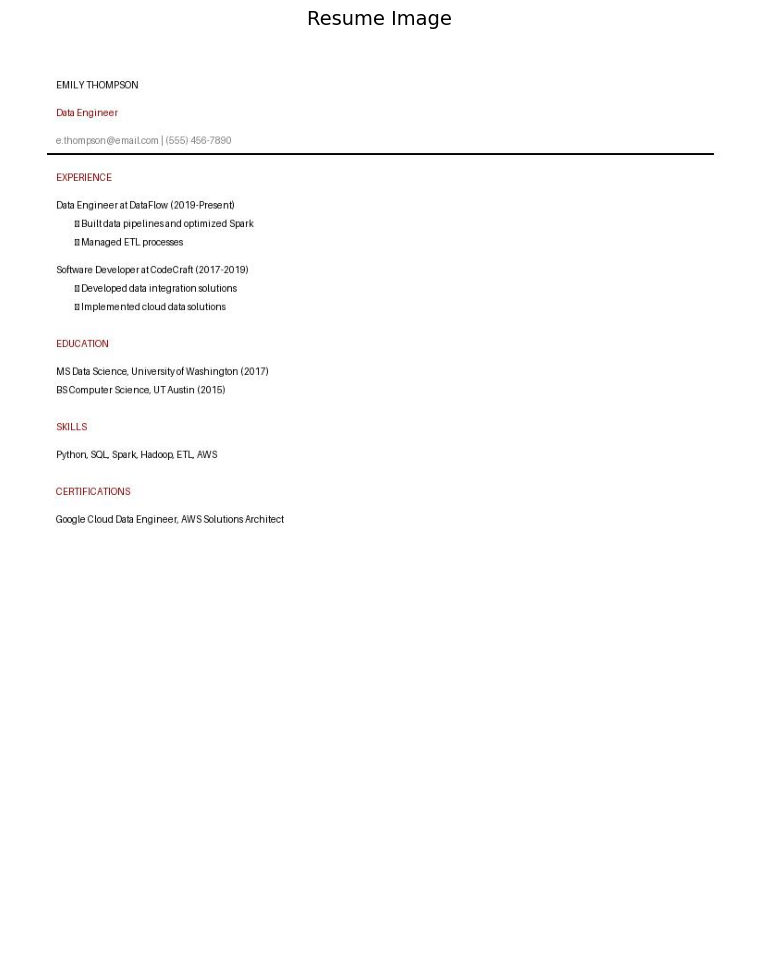

True

In [31]:
display_image(image_path="/Users/siddharthshailendra/Resume_Shortlister_using_llm_basic/resume_images/emily_resume.jpg", title="Resume Image")

In [32]:
# Function to extract text from resume image using LLM
def extract_text_from_resume(image_path):
    """Use the multimodal LLM to extract text from a resume image"""
    if not os.path.exists(image_path):
        return f"Image not found: {image_path}"
    
    prompt = """Please extract ALL the text from this resume with high accuracy. Return the complete text exactly as it appears, preserving the structure and formatting. Include every section, bullet point, and detail.

Important: Be extremely thorough and precise in your extraction. Don't summarize or paraphrase - extract the exact text:"""
    
    response = llm.invoke(prompt, image_path)
    return response


In [33]:
# Function to parse extracted text into structured data
def parse_extracted_resume_text(extracted_text, candidate_name):
    """Parse the extracted text into structured resume data"""
    # This is a simple parser - in a real application, you'd want a more sophisticated approach
    resume_data = {
        "name": candidate_name,
        "email": "",
        "phone": "",
        "experience": "",
        "education": "",
        "skills": "",
        "certifications": "",
        "summary": "",
        "projects": ""
    }
    
    # Extract email
    import re
    email_match = re.search(r'[\w\.-]+@[\w\.-]+\.\w+', extracted_text)
    if email_match:
        resume_data["email"] = email_match.group(0)
    
    # Extract phone (simple pattern)
    phone_match = re.search(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', extracted_text)
    if phone_match:
        resume_data["phone"] = phone_match.group(0)
    
    # Extract sections using keyword matching (simplified)
    lines = extracted_text.split('\n')
    current_section = None
    
    for line in lines:
        line_lower = line.lower()
        
        if 'experience' in line_lower and len(line.strip()) < 20:  # Section header
            current_section = 'experience'
        elif 'education' in line_lower and len(line.strip()) < 20:
            current_section = 'education'
        elif 'skill' in line_lower and len(line.strip()) < 20:
            current_section = 'skills'
        elif 'certification' in line_lower and len(line.strip()) < 20:
            current_section = 'certifications'
        elif 'summary' in line_lower and len(line.strip()) < 20:
            current_section = 'summary'
        elif 'project' in line_lower and len(line.strip()) < 20:
            current_section = 'projects'
        elif current_section and line.strip():
            # Add content to the current section
            if resume_data[current_section]:
                resume_data[current_section] += " " + line.strip()
            else:
                resume_data[current_section] = line.strip()
    
    return resume_data


In [34]:
# Extract text from resume images and create documents
resumes = []
extracted_data = []

print("🔍 Extracting text from resume images...")

🔍 Extracting text from resume images...


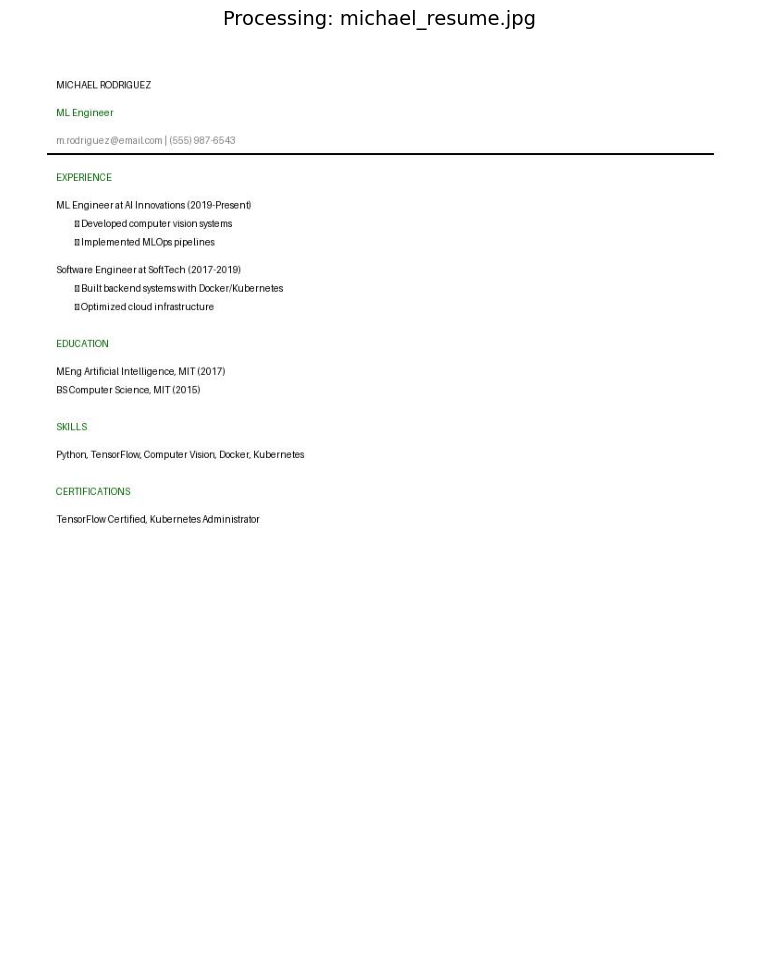

Extracting text from michael_resume.jpg...
✅ Extracted data for Michael
---


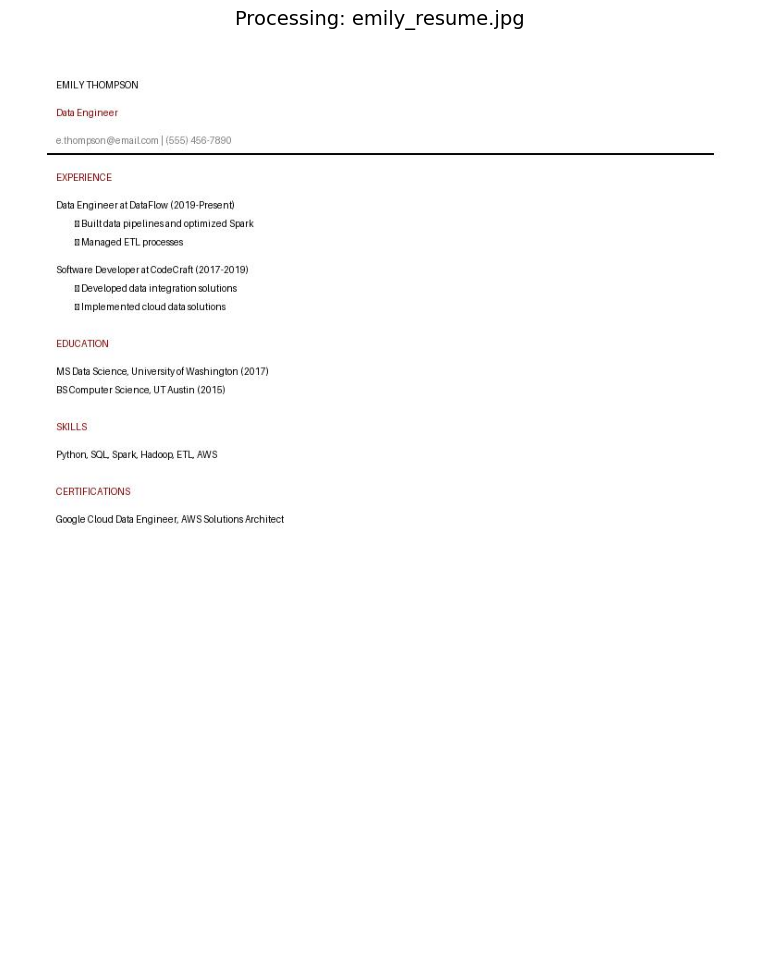

Extracting text from emily_resume.jpg...
✅ Extracted data for Emily
---


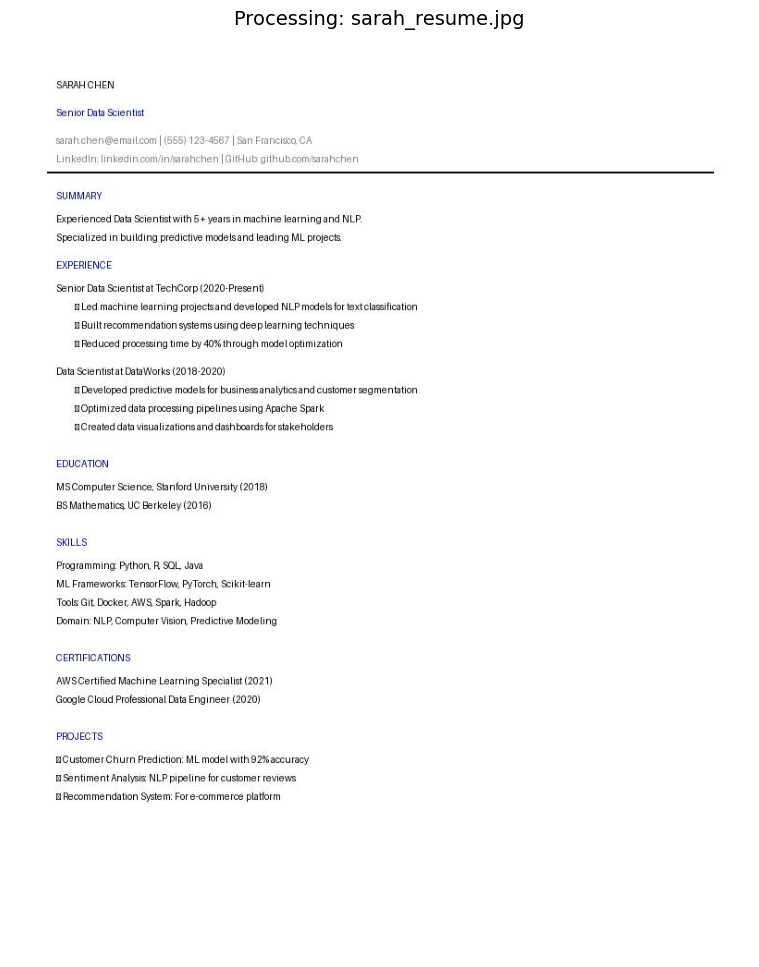

Extracting text from sarah_resume.jpg...
✅ Extracted data for Sarah
---

📋 Extracted Resume Data:

Candidate 1: Michael
Email: 
Experience: [Company Name Redacted], [Position Title Redacted], [Employment Dates Redacted] - Responsible for [J...
Skills: - Proficient in [Software/Language Redacted] - Strong analytical skills - Excellent communication an...

Candidate 2: Emily
Email: 
Experience: [Company Name Redacted], [Position Title Redacted] - Dates of Employment: [Start Date Redacted] - [E...
Skills: - Proficient in Microsoft Office Suite - Strong customer service skills - Excellent communication an...

Candidate 3: Sarah
Email: 
Experience: ...
Skills: - Proficient in [Software redacted] - Excellent verbal and written communication skills - Strong pro...


In [35]:
# Process each resume image
resume_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]

for resume_file in resume_files:
    image_path = os.path.join(IMAGE_DIR, resume_file)
    
    # Display the resume
    display_image(image_path, f"Processing: {resume_file}")
    
    # Extract text from the resume image
    print(f"Extracting text from {resume_file}...")
    extracted_text = extract_text_from_resume(image_path)
    
    # Parse the extracted text
    candidate_name = resume_file.replace('_resume.jpg', '').replace('_', ' ').title()
    resume_data = parse_extracted_resume_text(extracted_text, candidate_name)
    
    # Store the extracted data
    extracted_data.append({
        "image_path": image_path,
        "extracted_text": extracted_text,
        "parsed_data": resume_data
    })
    
    # Add to resumes list for vector store
    resumes.append({
        "id": len(resumes) + 1,
        "name": resume_data["name"],
        "email": resume_data["email"],
        "experience": resume_data.get("experience", ""),
        "education": resume_data.get("education", ""),
        "skills": resume_data.get("skills", ""),
        "certifications": resume_data.get("certifications", ""),
        "summary": resume_data.get("summary", ""),
        "projects": resume_data.get("projects", ""),
        "image_path": image_path
    })
    
    print(f"✅ Extracted data for {candidate_name}")
    print("---")

# Display extracted data
print("\n📋 Extracted Resume Data:")
for i, data in enumerate(extracted_data):
    print(f"\nCandidate {i+1}: {data['parsed_data']['name']}")
    print(f"Email: {data['parsed_data']['email']}")
    print(f"Experience: {data['parsed_data'].get('experience', '')[:100]}...")
    print(f"Skills: {data['parsed_data'].get('skills', '')[:100]}...")

In [36]:
# Function to create documents for vector store FROM EXTRACTED TEXT
def create_documents_from_extracted_data(resume_data):
    documents = []
    for resume in resume_data:
        # Use the actual extracted text for the vector store
        text = f"{resume['name']} - {resume['email']}. Experience: {resume['experience']} Education: {resume['education']} Skills: {resume['skills']} Certifications: {resume['certifications']} Summary: {resume['summary']} Projects: {resume['projects']}"
        metadata = {
            "id": resume['id'], 
            "name": resume['name'],
            "image_path": resume['image_path'],
            "email": resume['email']
        }
        documents.append({"page_content": text, "metadata": metadata})
    return documents

# Create vector store FROM EXTRACTED TEXT
documents = create_documents_from_extracted_data(resumes)

try:
    texts = [doc["page_content"] for doc in documents]
    metadatas = [doc["metadata"] for doc in documents]
    
    vectorstore = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print("✅ FAISS vector store created FROM EXTRACTED TEXT")
except Exception as e:
    print(f"❌ Vector store creation failed: {e}")
    # Fallback to simple retriever
    class SimpleRetriever:
        def get_relevant_documents(self, query):
            query_words = set(query.lower().split())
            results = []
            for doc in documents:
                doc_words = set(doc["page_content"].lower().split())
                score = len(query_words.intersection(doc_words)) / len(query_words.union(doc_words)) if query_words else 0
                results.append((score, doc))
            results.sort(key=lambda x: x[0], reverse=True)
            return [doc for score, doc in results[:3]]
    
    retriever = SimpleRetriever()
else:
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})


✅ FAISS vector store created FROM EXTRACTED TEXT



🧪 Testing multimodal shortlisting WITH EXTRACTED TEXT...


/var/folders/py/4k88vyb50_534cj29tc3l25c0000gn/T/ipykernel_4202/2808562415.py:12: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG15GFamilyCommandBuffer: 0x10b358d00>
    label = <none> 
    device = <AGXG15GDevice: 0x15bda9800>
        name = Apple M3 
    commandQueue = <AGXG15GFamilyCommandQueue: 0x10f81a200>
        label = <none> 
        device = <AGXG15GDevice: 0x15bda9800>
            name = Apple M3 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficie

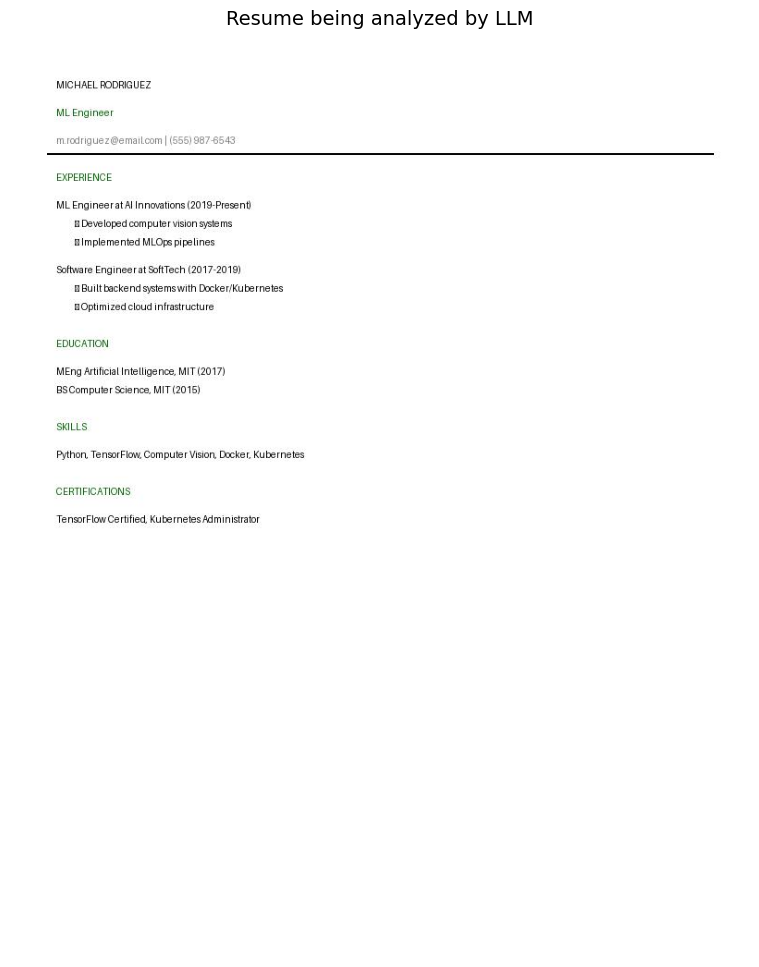

📋 Results based on EXTRACTED TEXT:
 Based on the job requirements, the candidate with machine learning and Python experience is Michael. His resume clearly states his proficiency in these areas, which aligns with the job requirements. Additionally, he has relevant education and skills that are likely to be beneficial for the role. 


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG15GFamilyCommandBuffer: 0x15596d320>
    label = <none> 
    device = <AGXG15GDevice: 0x15bda9800>
        name = Apple M3 
    commandQueue = <AGXG15GFamilyCommandQueue: 0x10f81a200>
        label = <none> 
        device = <AGXG15GDevice: 0x15bda9800>
            name = Apple M3 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG15GFamilyCommandBuffer: 0x154a70830>
    label = <none> 
    device = <AGXG15GDevice: 0x15bda9800>
        name = Apple M3 
    commandQueue = <AGXG15GFamilyCommandQueue: 0x10f81a200>
        label = <none> 
        device = <AGXG15GDev

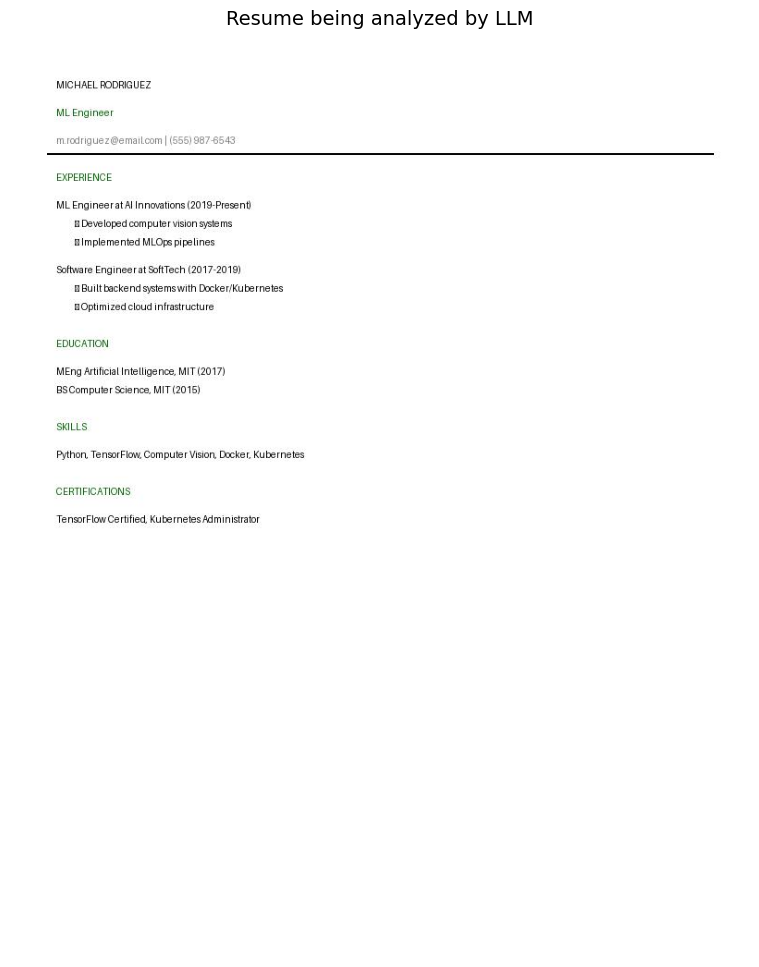


📋 Data science results (with image analysis):
 Based on the job requirements, which include data science and cloud experience, the candidate with the most relevant experience is Michael. He has worked as a data scientist at two different companies, which suggests he has hands-on experience in this field. Additionally, his education in both bachelor's and master's degrees in computer science further supports his qualifications for the role. Emily and Sarah have skills that are not directly related to the job requirements, so they may not be the best fit for this position. 

🔍 Multimodal capabilities: Enabled
✅ Successfully extracted text from resume images and used it for analysis!

📁 INSTRUCTIONS FOR ADDING YOUR OWN RESUME IMAGES:

1. Place your resume images in the '/Users/siddharthshailendra/Resume_Shortlister_using_llm_basic/resume_images' folder
2. Name them appropriately (e.g., 'john_doe_resume.jpg')
3. The system will automatically extract text from them
4. Run the code again to

In [37]:
# Enhanced shortlisting function that uses EXTRACTED TEXT
def shortlist_candidates(query, specific_candidate=None, image_path=None):
    try:
        # Retrieve relevant candidates BASED ON EXTRACTED TEXT
        if hasattr(retriever, 'get_relevant_documents'):
            if specific_candidate:
                # If a specific candidate is requested, find their document
                docs = [doc for doc in documents if doc["metadata"]["name"].lower() == specific_candidate.lower()]
                if not docs:
                    return f"Candidate {specific_candidate} not found."
            else:
                docs = retriever.get_relevant_documents(query)
        else:
            docs = retriever.invoke(query)
        
        # Prepare context FROM EXTRACTED TEXT
        context = "\n\n".join([
            f"Candidate: {doc.metadata['name'] if hasattr(doc, 'metadata') else doc['metadata']['name']}\n"
            f"Details: {doc.page_content if hasattr(doc, 'page_content') else doc['page_content']}"
            for doc in docs
        ])
        
        # Determine which image to use
        use_image_path = image_path
        if not use_image_path and len(docs) > 0:
            # Use the first candidate's image if no specific image provided
            first_doc = docs[0]
            candidate_image_path = first_doc.metadata['image_path'] if hasattr(first_doc, 'metadata') else first_doc['metadata']['image_path']
            if candidate_image_path and os.path.exists(candidate_image_path):
                use_image_path = candidate_image_path
        
        # Prepare prompt based on whether we have image input
        if use_image_path and multimodal_capable and os.path.exists(use_image_path):
            # Display the image that will be analyzed
            display_image(use_image_path, "Resume being analyzed by LLM")
            
            prompt = f"""You are an expert recruiter. Analyze these candidates and recommend the best one based on the job requirements.

Job Requirements: {query}

Candidates (text extracted from their resumes):
{context}

Please analyze the candidates and recommend the best fit. Provide a concise analysis (3-4 sentences):"""
            
            # Get multimodal response
            response = llm.invoke(prompt, use_image_path)
            
        else:
            prompt = f"""You are an expert recruiter. Analyze these candidates and recommend the best one.

Job Requirements: {query}

Candidates (text extracted from their resumes):
{context}

Please provide a concise analysis (3-4 sentences) and recommend the best candidate:"""
            
            # Get text-only response
            response = llm.invoke(prompt)
        
        return response
        
    except Exception as e:
        return f"Error: {str(e)}"

# Test the multimodal system WITH EXTRACTED TEXT
print("\n🧪 Testing multimodal shortlisting WITH EXTRACTED TEXT...")

# Test 1: Query with candidates found through extracted text
query1 = "Find candidates with machine learning and Python experience"
result1 = shortlist_candidates(query1)
print("📋 Results based on EXTRACTED TEXT:")
print(result1)

# Test 2: Query with image analysis
query2 = "Looking for data scientists with cloud experience"
result2 = shortlist_candidates(query2)
print("\n📋 Data science results (with image analysis):")
print(result2)

print(f"\n🔍 Multimodal capabilities: {'Enabled' if multimodal_capable else 'Disabled'}")
if not multimodal_capable:
    print("💡 Install a multimodal model: ollama pull llava")
else:
    print("✅ Successfully extracted text from resume images and used it for analysis!")

# Instructions for adding your own resume images
print(f"""
📁 INSTRUCTIONS FOR ADDING YOUR OWN RESUME IMAGES:

1. Place your resume images in the '{IMAGE_DIR}' folder
2. Name them appropriately (e.g., 'john_doe_resume.jpg')
3. The system will automatically extract text from them
4. Run the code again to analyze your actual resumes

The system will:
1. Extract text from your resume images using multimodal LLM
2. Parse the extracted text into structured data
3. Use the extracted text for candidate matching and analysis
4. Allow visual analysis of the resumes when needed
""")